[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/miokobayashii/summerschool2022/blob/main/day01/HandWrittenDigits.ipynb)


# Introduction to Generative Adversarial Networks

## Generate handwritten digits images from noize images

- This source codes refer to "GANs in Action: Deep learning with Generative Adversarial Networks" , Bok, Vladimir; Langr, Jakub. 
https://www.amazon.co.uk/GANs-Action-learning-Generative-Adversarial-ebook/dp/B09781PX97/ref=sr_1_1?crid=1VXTH6YGJ4WIL&keywords=GANs+in+Action%3A+Deep+learning+with+Generative+Adversarial+Networks&qid=1654557614&sprefix=gans+in+action+deep+learning+with+generative+adversarial+networks%2Caps%2C263&sr=8-1

### Import all the packages and libraries
"keras.datasets import mnist" means that we import the MNITST dataset of handwritten digits.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
#from keras.optimizers import Adam
from keras.optimizers import adam_v2



### Define the dimentions of our model and dataset.


In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)    

z_dim = 100


In [ ]:

def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

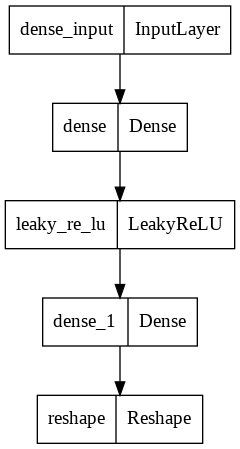

In [ ]:
generator = build_generator(img_shape, z_dim)

from tensorflow.keras.utils import plot_model
plot_model(generator, to_file='model.png', show_shapes=True)


In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator(img_shape)
plot_model(discriminator, to_file='model.png', show_shapes=True)
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model



In [ ]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=adam_v2.Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam())

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

1000 [D loss: 0.071243, acc.: 100.00%] [G loss: 2.809631]
2000 [D loss: 0.113623, acc.: 94.92%] [G loss: 5.843167]
3000 [D loss: 0.117108, acc.: 97.27%] [G loss: 5.508771]
4000 [D loss: 0.227723, acc.: 91.80%] [G loss: 4.785043]
5000 [D loss: 0.241996, acc.: 88.67%] [G loss: 3.645802]
6000 [D loss: 0.274896, acc.: 87.89%] [G loss: 4.338737]
7000 [D loss: 0.413478, acc.: 83.98%] [G loss: 4.298920]
8000 [D loss: 0.348001, acc.: 83.98%] [G loss: 4.243644]
9000 [D loss: 0.429774, acc.: 83.59%] [G loss: 3.662110]
10000 [D loss: 0.318597, acc.: 85.55%] [G loss: 4.022511]
11000 [D loss: 0.237119, acc.: 90.62%] [G loss: 4.170151]
12000 [D loss: 0.622584, acc.: 71.48%] [G loss: 2.665219]
13000 [D loss: 0.246652, acc.: 92.19%] [G loss: 3.018755]
14000 [D loss: 0.233606, acc.: 89.84%] [G loss: 3.820586]
15000 [D loss: 0.527376, acc.: 76.17%] [G loss: 2.975062]
16000 [D loss: 0.342702, acc.: 85.94%] [G loss: 2.863749]
17000 [D loss: 0.290145, acc.: 86.33%] [G loss: 2.983174]
18000 [D loss: 0.36261

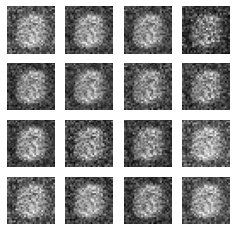

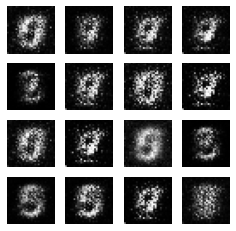

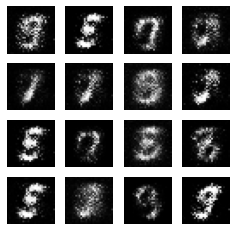

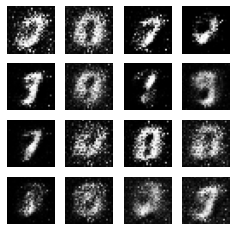

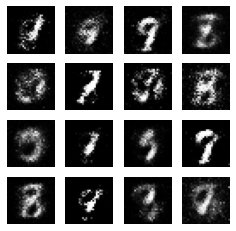

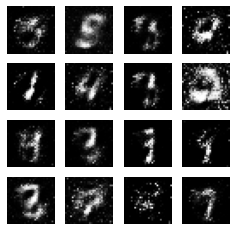

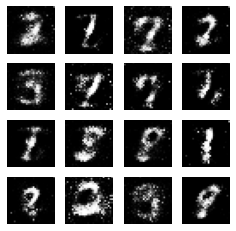

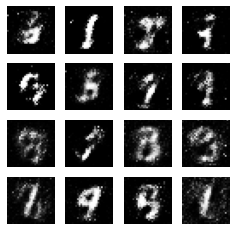

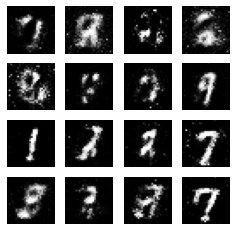

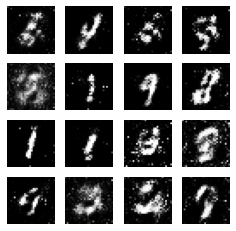

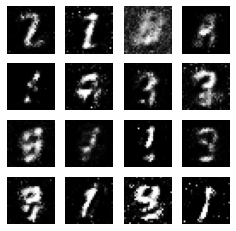

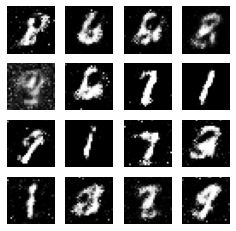

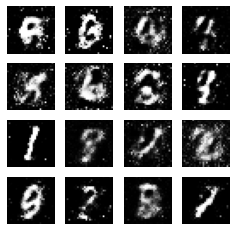

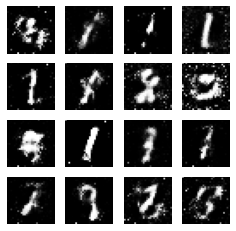

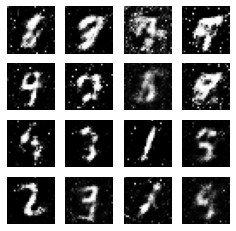

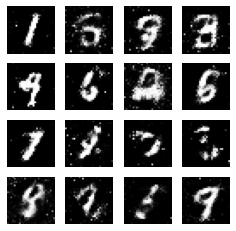

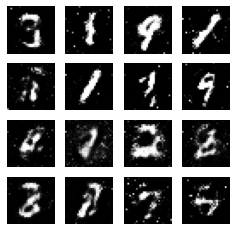

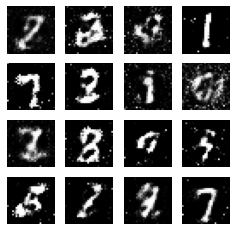

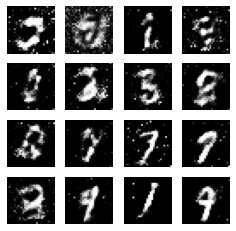

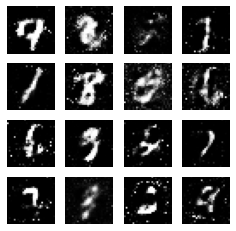

In [ ]:
# Set hyperparameters
iterations = 20000
batch_size = 256
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

NameError: ignored